In [1]:
import getpass
import mysql.connector
import pandas as pd

def connect_and_init(db_name):
    password = getpass.getpass("请输入你的 MySQL 密码：")
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password=password,
        charset="utf8mb4"
    )
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name}")
    cursor.execute(f"USE {db_name}")
    return conn, cursor

conn, cursor = connect_and_init("test_db")


# Defining Table Schema

In [4]:
query = """
CREATE TABLE IF NOT EXISTS student(
    student_id INT PRIMARY KEY,
    name VARCHAR(20),  -- maximum 20 characters
    major VARCHAR(20)         
)
"""

cursor.execute(query)

### read table using pd

In [5]:
from pandas.io.sql import DatabaseError
def read_table(name):
    try:
        df = pd.read_sql("SELECT * FROM student", conn, index_col='student_id')
        display(df)
    except DatabaseError as e:
        print('Table does not exist or other error.')


### describe table and show result using pd

In [6]:
def describe_table(name):
    cursor.execute(f'DESCRIBE {name}')
    df = pd.DataFrame(cursor.fetchall(), columns=[i[0] for i in cursor.description])
    display(df)

In [7]:
describe_table('student')

,Field,Type,Null,Key,Default,Extra
0,student_id,int,NO,PRI,None,auto_increment
1,name,varchar(20),YES,,None,
2,major,varchar(20),YES,,None,


### DELETE a TABLE

In [8]:
cursor.execute("DROP TABLE student")

#### add the table back

In [9]:
query = """
CREATE TABLE IF NOT EXISTS student(
    student_id INT PRIMARY KEY,
    name VARCHAR(20),  -- maximum 20 characters
    major VARCHAR(20)         
)
"""

cursor.execute(query)

# ALTER: add a new column

ALTER TABLE table_name

ADD column_name datatype;

--------------------------------------

ALTER TABLE table_name

DROP COLUMN column_name;

--------------------------------------

ALTER TABLE table_name

MODIFY COLUMN column_name new_datatype;


In [10]:
query = "ALTER TABLE student ADD gpa DECIMAL(3, 2)"
cursor.execute(query)
describe_table("student")

,Field,Type,Null,Key,Default,Extra
0,student_id,int,NO,PRI,None,
1,name,varchar(20),YES,,None,
2,major,varchar(20),YES,,None,
3,gpa,"decimal(3,2)",YES,,None,


### delete a column

In [11]:
query = "ALTER TABLE student DROP COLUMN gpa"
cursor.execute(query)
describe_table("student")

,Field,Type,Null,Key,Default,Extra
0,student_id,int,NO,PRI,None,
1,name,varchar(20),YES,,None,
2,major,varchar(20),YES,,None,


# Inserting Data

INSERT INTO table_name (column1, column2, ...)

VALUES (value1, value2, ...);


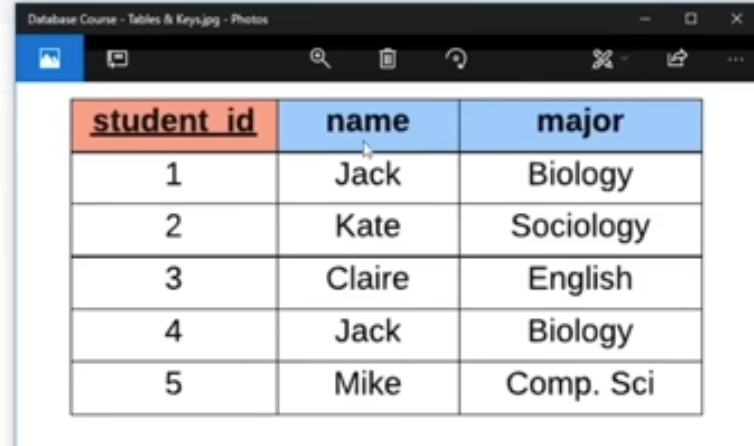
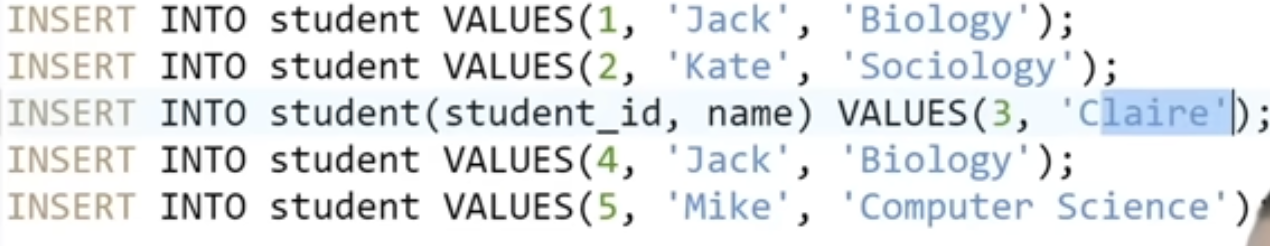

### add a student

In [12]:
query = """INSERT INTO student VALUES(1, 'Jack', 'Biology')"""
cursor.execute(query)
read_table('student') # SELECT * FROM student, get all the information from table

,name,major
student_id,,
1,Jack,Biology


### add the second student

In [13]:
query = """INSERT INTO student VALUES(2, 'Kate', 'Sociology')"""
cursor.execute(query)
read_table('student')

,name,major
student_id,,
1,Jack,Biology
2,Kate,Sociology


### add a student WITHOUT major

In [14]:
query = """INSERT INTO student(student_id, name) VALUES(3, 'Claire')"""
cursor.execute(query)
read_table('student')

,name,major
student_id,,
1,Jack,Biology
2,Kate,Sociology
3,Claire,None


### add the rest students

In [15]:
query = """
INSERT INTO student 
VALUES(4, 'Jack', 'Biology'),
      (5, 'Mike', 'Computer Science')
"""
cursor.execute(query)
read_table('student')

,name,major
student_id,,
1,Jack,Biology
2,Kate,Sociology
3,Claire,None
4,Jack,Biology
5,Mike,Computer Science


# Constraint

#### encapsolate cursor.execute with error checking.

In [16]:
def run(ar_query):
    try:
        cursor.execute(ar_query)
        print('Rows affected:', cursor.rowcount)
    except Exception as e:
        if 'Duplicate' in str(e):
            print('Error: Duplicate Major')
        elif 'null' in str(e):
            print('Error: Name can not be NULL')
        else:
            print('Other Error:', e)
    finally:
        print('process done.')
    return cursor


### start over

In [17]:
query = 'DROP TABLE student'
run(query)


Rows affected: 0
process done.


In [18]:
read_table('student')

Table does not exist or other error.


2 Constraints:
- Name can't be NULL
- major has to be UNIQUE

In [19]:
query = """
CREATE TABLE IF NOT EXISTS student(
    student_id INT PRIMARY KEY,
    name VARCHAR(20) NOT NULL, 
    major VARCHAR(20) UNIQUE         
)
"""

run(query)

Rows affected: 0
process done.


### Let's try duplicate major

In [20]:
query = """
INSERT INTO student 
VALUES
(1, 'Jack', 'Biology'),
(2, 'Kate', 'Sociology'),
(3, 'Claire', 'English'),
(4, 'Jack', 'Biology'),
(5, 'Mike', 'Computer Science')
"""

run(query)

read_table('student')

Error: Duplicate Major
process done.


,name,major
student_id,,


There are 2 biology majors.

### Let's try NULL name

In [21]:
query = """
INSERT INTO student 
VALUES
(1, 'Jack', 'Biology'),
(2, 'Kate', 'Sociology'),
(3, 'Claire', 'English'),
(4, NULL, 'Chinese'),
(5, 'Mike', 'Computer Science')
"""

run(query)
read_table('student')

Error: Name can not be NULL
process done.


,name,major
student_id,,


### Start over again

In [22]:
query = 'DROP TABLE student'
run(query)

Rows affected: 0
process done.


### Set a DEFAULT major

In [23]:
query = """
CREATE TABLE IF NOT EXISTS student(
    student_id INT PRIMARY KEY,
    name VARCHAR(20), 
    major VARCHAR(20) DEFAULT 'undecided'        
)
"""

run(query)

Rows affected: 0
process done.


In [24]:
query = """
INSERT INTO student (student_id, name)
VALUES 
(1, 'Jack')
"""

run(query)

read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Jack,undecided


### drop again

In [25]:
query = 'DROP TABLE student'
run(query)

Rows affected: 0
process done.


### auto increase primary key

In [26]:
query = """
CREATE TABLE IF NOT EXISTS student(
    student_id INT PRIMARY KEY AUTO_INCREMENT,
    name VARCHAR(20), 
    major VARCHAR(20)         
)
"""

run(query)

Rows affected: 0
process done.


Here we don't need to insert the student_id

In [27]:
query = """
INSERT INTO student (name, major)
VALUES
('Jack', 'Biology'),
('Kate', 'Sociology'),
('Claire', 'English'),
('Jack', 'Chinese'),
('Mike', 'Computer Science')
"""

run(query)

read_table('student')

Rows affected: 5
process done.


,name,major
student_id,,
1,Jack,Biology
2,Kate,Sociology
3,Claire,English
4,Jack,Chinese
5,Mike,Computer Science


# Update row(s)

UPDATE table_name

SET column1 = value1, column2 = value2

WHERE condition;


### change the name of Biology to Bio

In [28]:
query = """ 
UPDATE student
SET major = 'Bio'
WHERE major = 'Biology'
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Jack,Bio
2,Kate,Sociology
3,Claire,English
4,Jack,Chinese
5,Mike,Computer Science


### computer science to comp sci

In [29]:
query = """ 
UPDATE student
SET major = 'Comp Sci'
WHERE major = 'Computer Science'
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Jack,Bio
2,Kate,Sociology
3,Claire,English
4,Jack,Chinese
5,Mike,Comp Sci


### change the major of the student with student id 4 to Chemistry

In [30]:
query = """ 
UPDATE student
SET major = 'Chemistry'
WHERE student_id = 4
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Jack,Bio
2,Kate,Sociology
3,Claire,English
4,Jack,Chemistry
5,Mike,Comp Sci


### any student who is either bio or chem to bio-chem

In [31]:
query = """ 
UPDATE student
SET major = 'Biochemistry'
WHERE major = 'Bio' OR major = 'Chemistry'
"""
run(query)
read_table('student')

Rows affected: 2
process done.


,name,major
student_id,,
1,Jack,Biochemistry
2,Kate,Sociology
3,Claire,English
4,Jack,Biochemistry
5,Mike,Comp Sci


### do multiple updates

In [32]:
query = """ 
UPDATE student
SET name = 'Austin', major = 'undecided'
WHERE student_id = 1
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Austin,undecided
2,Kate,Sociology
3,Claire,English
4,Jack,Biochemistry
5,Mike,Comp Sci


In [33]:
query = """ 
UPDATE student
SET major = 'undecided'
"""
run(query)
read_table('student')

Rows affected: 4
process done.


,name,major
student_id,,
1,Austin,undecided
2,Kate,undecided
3,Claire,undecided
4,Jack,undecided
5,Mike,undecided


# Delete row(s)

DELETE FROM table_name

WHERE condition;


In [34]:
query = """ 
DELETE FROM student
WHERE student_id = 5
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Austin,undecided
2,Kate,undecided
3,Claire,undecided
4,Jack,undecided


In [35]:
query = """ 
DELETE FROM student
WHERE name = 'Austin' AND major = 'Computer Science'
"""
run(query)
read_table('student')

Rows affected: 0
process done.


,name,major
student_id,,
1,Austin,undecided
2,Kate,undecided
3,Claire,undecided
4,Jack,undecided


In [36]:
query = """ 
DELETE FROM student
WHERE name = 'Austin' AND major = 'undecided'
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
2,Kate,undecided
3,Claire,undecided
4,Jack,undecided


### add it back using INSERT

In [37]:
query = """ 
INSERT INTO student VALUES (1, 'Austin', 'undecided')
"""
run(query)
read_table('student')

Rows affected: 1
process done.


,name,major
student_id,,
1,Austin,undecided
2,Kate,undecided
3,Claire,undecided
4,Jack,undecided


# Basic Queries

## SELECT

SELECT column1, column2, ...

FROM table_name

WHERE condition;


### encapsolate a function to run the SELECT

In [38]:
def select(ar_query, verbose=True):
    try:
        cursor.execute(ar_query)
        results = cursor.fetchall()
        if not results:
            if verbose:
                print('Select Nothing.')
            return pd.DataFrame() # return empty df
        else:
            columns = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=results, columns=columns)
            if verbose:
                print(f'return {len(df)} row(s) of data.')
            return df
    except Exception as e:
        print('Error:', e)
        return pd.DataFrame()

    

### Encapsolate a function to initialize the table 

In [39]:
def initialize_student():
    query = ''' 
    DELETE FROM student
    '''
    run(query)

    query = ''' 
    INSERT INTO student 
    VALUES 
    (1, 'Jack', 'Biology'),
    (2, 'Kate', 'Sociology'),
    (3, 'Claire', 'Chemistry'),
    (4, 'Jack', 'Biology'),
    (5, 'Mike', 'Computer Science')
    '''
    run(query)

In [40]:
initialize_student()

Rows affected: 4
process done.
Rows affected: 5
process done.


### all information

In [41]:
query = 'SELECT * FROM student'
select(query)

return 5 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,2,Kate,Sociology
2,3,Claire,Chemistry
3,4,Jack,Biology
4,5,Mike,Computer Science


### only name and major

In [42]:
query = 'SELECT name, major FROM student'
select(query)

return 5 row(s) of data.


,name,major
0,Jack,Biology
1,Kate,Sociology
2,Claire,Chemistry
3,Jack,Biology
4,Mike,Computer Science


More specific

In [43]:
query = 'SELECT student.name, student.major FROM student'
select(query)

return 5 row(s) of data.


,name,major
0,Jack,Biology
1,Kate,Sociology
2,Claire,Chemistry
3,Jack,Biology
4,Mike,Computer Science


### ORDER BY name

In [44]:
query = '''
SELECT student.name, student.major 
FROM student
ORDER BY name
'''
select(query)

return 5 row(s) of data.


,name,major
0,Claire,Chemistry
1,Jack,Biology
2,Jack,Biology
3,Kate,Sociology
4,Mike,Computer Science


### DESCENDING ORDER by name

In [45]:
query = '''
SELECT student.name, student.major 
FROM student
ORDER BY name DESC
'''
select(query)

return 5 row(s) of data.


,name,major
0,Mike,Computer Science
1,Kate,Sociology
2,Jack,Biology
3,Jack,Biology
4,Claire,Chemistry


### order by student_id

ASC for ascending

In [46]:
query = '''
SELECT student.name, student.major, student.student_id
FROM student
ORDER BY student_id DESC
'''
select(query)

return 5 row(s) of data.


,name,major,student_id
0,Mike,Computer Science,5
1,Jack,Biology,4
2,Claire,Chemistry,3
3,Kate,Sociology,2
4,Jack,Biology,1


### order by major, then order by student_id

In [47]:
query = '''
SELECT *
FROM student
ORDER BY major, student_id
'''
select(query)

return 5 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,4,Jack,Biology
2,3,Claire,Chemistry
3,5,Mike,Computer Science
4,2,Kate,Sociology


In [48]:
query = '''
SELECT *
FROM student
ORDER BY major, student_id DESC
'''
select(query)

return 5 row(s) of data.


,student_id,name,major
0,4,Jack,Biology
1,1,Jack,Biology
2,3,Claire,Chemistry
3,5,Mike,Computer Science
4,2,Kate,Sociology


### LIMIT only 2

In [49]:
query = '''
SELECT *
FROM student
LIMIT 2
'''
select(query)

return 2 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,2,Kate,Sociology


### ORDER BY and LIMIT

SELECT ...

FROM ...

[WHERE ...]

ORDER BY ...

LIMIT ...


In [50]:
query = '''
SELECT *
FROM student
ORDER BY student_id
LIMIT 2
'''
select(query)

return 2 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,2,Kate,Sociology


### WHERE condition for SELECT

In [51]:
query = '''
SELECT *
FROM student
WHERE major = 'Biology'
'''
select(query)

return 2 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,4,Jack,Biology


### add more conditions

In [53]:
query = '''
SELECT *
FROM student
WHERE major = 'Biology' AND student_id = 1
'''
select(query)

return 1 row(s) of data.


,student_id,name,major
0,1,Jack,Biology


### select major not chem

In [54]:
query = '''
SELECT *
FROM student
WHERE major <> 'Chemistry'
'''
select(query)

return 4 row(s) of data.


,student_id,name,major
0,1,Jack,Biology
1,2,Kate,Sociology
2,4,Jack,Biology
3,5,Mike,Computer Science


In [56]:
query = '''
SELECT *
FROM student
WHERE student_id < 3 AND name <> 'Jack'
'''
select(query)

return 1 row(s) of data.


,student_id,name,major
0,2,Kate,Sociology


# IN

In [57]:
query = '''
SELECT *
FROM student
WHERE name IN ('Claire', 'Kate', 'Mike')
'''
select(query)

return 3 row(s) of data.


,student_id,name,major
0,2,Kate,Sociology
1,3,Claire,Chemistry
2,5,Mike,Computer Science


In [59]:
query = '''
SELECT *
FROM student
WHERE name IN ('Claire', 'Kate', 'Mike') AND student_id < 3
'''
select(query)

return 1 row(s) of data.


,student_id,name,major
0,2,Kate,Sociology
